<a href="https://colab.research.google.com/github/Snigdha-new/decision-fatigue-cuda-system/blob/main/DECISION_FATIGUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!nvidia-smi


Sun Jan 18 15:08:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             26W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [51]:
!pip install pandas numpy scikit-learn numba matplotlib


In [52]:
import pandas as pd

df = pd.read_csv("screen_time.csv")
df


,date,total_minutes,pickups,late_night_minutes,app_switches,short_sessions,social_minutes
0,01-01-2026,420,55,60,40,25,140
1,02-01-2026,390,70,90,65,40,180
2,03-01-2026,450,45,30,25,15,120
3,04-01-2026,500,85,120,90,60,220
4,05-01-2026,430,50,45,35,20,150
5,06-01-2026,480,75,100,80,55,210
6,07-01-2026,400,40,20,20,10,100


In [53]:
import numpy as np

df["late_night_ratio"] = df["late_night_minutes"] / df["total_minutes"]
df["fragmentation_score"] = (df["pickups"] + df["app_switches"]) / df["total_minutes"]
df["social_ratio"] = df["social_minutes"] / df["total_minutes"]
df["decision_signal"] = (df["app_switches"] + df["short_sessions"]) / df["total_minutes"]

df[[
    "date",
    "late_night_ratio",
    "fragmentation_score",
    "social_ratio",
    "decision_signal"
]]


,date,late_night_ratio,fragmentation_score,social_ratio,decision_signal
0,01-01-2026,0.142857,0.226190,0.333333,0.154762
1,02-01-2026,0.230769,0.346154,0.461538,0.269231
2,03-01-2026,0.066667,0.155556,0.266667,0.088889
3,04-01-2026,0.240000,0.350000,0.440000,0.300000
4,05-01-2026,0.104651,0.197674,0.348837,0.127907
5,06-01-2026,0.208333,0.322917,0.437500,0.281250
6,07-01-2026,0.050000,0.150000,0.250000,0.075000


In [54]:
def detect_overload(row):
    if row["late_night_ratio"] > 0.25 and row["fragmentation_score"] > 0.3:
        return "High"
    return "Low"

df["silent_overload"] = df.apply(detect_overload, axis=1)

df[["date", "silent_overload"]]


,date,silent_overload
0,01-01-2026,Low
1,02-01-2026,Low
2,03-01-2026,Low
3,04-01-2026,Low
4,05-01-2026,Low
5,06-01-2026,Low
6,07-01-2026,Low


In [55]:
baseline = df["decision_signal"].mean()

def detect_decision_fatigue(row):
    if row["decision_signal"] > baseline * 1.5:
        return "High"
    return "Low"

df["decision_fatigue"] = df.apply(detect_decision_fatigue, axis=1)

df[["date", "decision_fatigue"]]


,date,decision_fatigue
0,01-01-2026,Low
1,02-01-2026,Low
2,03-01-2026,Low
3,04-01-2026,High
4,05-01-2026,Low
5,06-01-2026,High
6,07-01-2026,Low


In [56]:
def explain(row):
    reasons = []
    if row["late_night_ratio"] > 0.25:
        reasons.append("High late-night usage")
    if row["fragmentation_score"] > 0.3:
        reasons.append("Frequent interruptions")
    if row["decision_signal"] > baseline * 1.5:
        reasons.append("High indecision behavior")
    return ", ".join(reasons) if reasons else "Behavior stable"

df["explanation"] = df.apply(explain, axis=1)

df[["date", "silent_overload", "decision_fatigue", "explanation"]]


,date,silent_overload,decision_fatigue,explanation
0,01-01-2026,Low,Low,Behavior stable
1,02-01-2026,Low,Low,Frequent interruptions
2,03-01-2026,Low,Low,Behavior stable
3,04-01-2026,Low,High,"Frequent interruptions, High indecision behavior"
4,05-01-2026,Low,Low,Behavior stable
5,06-01-2026,Low,High,"Frequent interruptions, High indecision behavior"
6,07-01-2026,Low,Low,Behavior stable


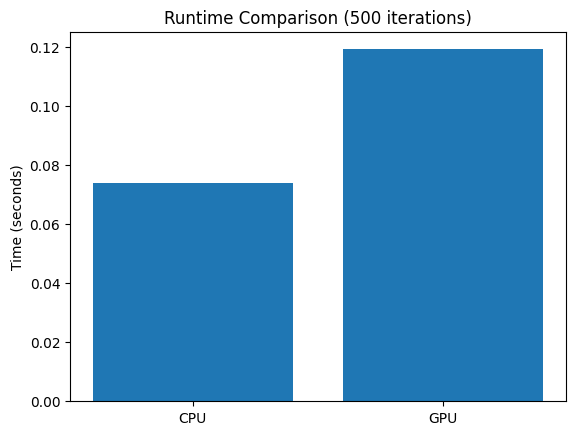

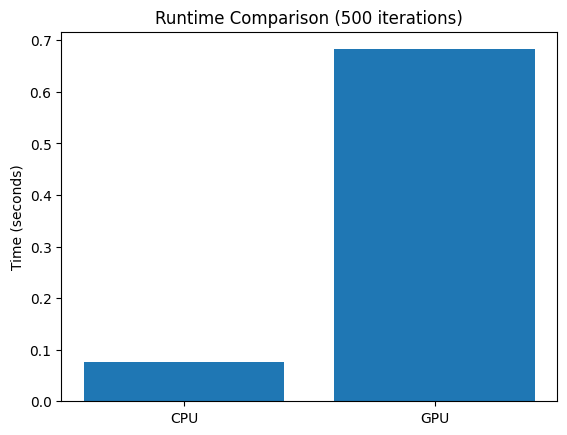

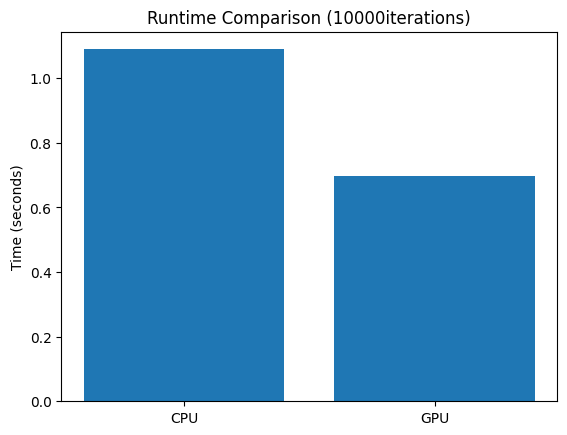

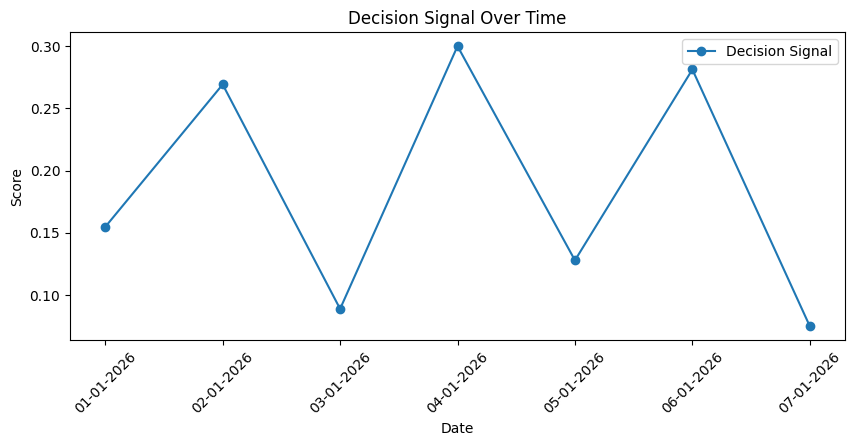

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["date"], df["decision_signal"], marker="o", label="Decision Signal")
plt.xticks(rotation=45)
plt.title("Decision Signal Over Time")
plt.ylabel("Score")
plt.xlabel("Date")
plt.legend()
plt.show()


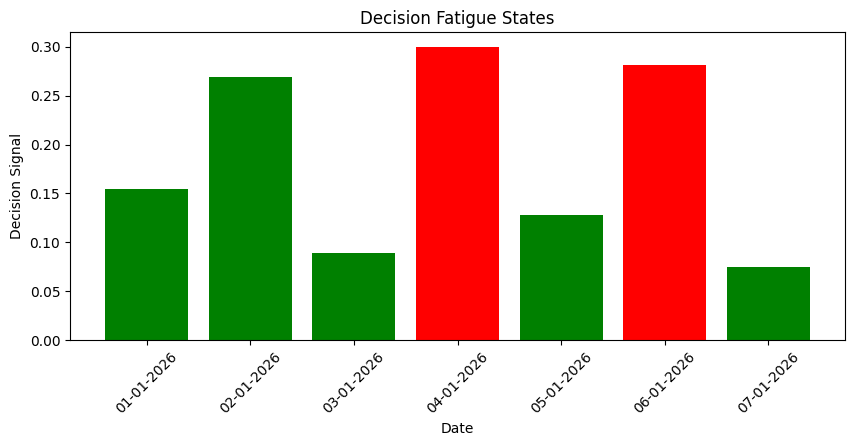

In [58]:
colors = df["decision_fatigue"].map({"High": "red", "Low": "green"})

plt.figure(figsize=(10,4))
plt.bar(df["date"], df["decision_signal"], color=colors)
plt.xticks(rotation=45)
plt.title("Decision Fatigue States")
plt.ylabel("Decision Signal")
plt.xlabel("Date")
plt.show()


In [59]:
import time

start = time.time()

for _ in range(1000):
    df["decision_signal"] = (df["app_switches"] + df["short_sessions"]) / df["total_minutes"]
    df["silent_overload"] = df.apply(detect_overload, axis=1)
    df["decision_fatigue"] = df.apply(detect_decision_fatigue, axis=1)

end = time.time()

print("CPU runtime (1000 iterations):", end - start, "seconds")


CPU runtime (1000 iterations): 1.1773154735565186 seconds


In [60]:
from numba import cuda
print("CUDA available:", cuda.is_available())


CUDA available: True


In [61]:
import numpy as np

app_switches_np = df["app_switches"].to_numpy(dtype=np.float32)
short_sessions_np = df["short_sessions"].to_numpy(dtype=np.float32)
total_minutes_np = df["total_minutes"].to_numpy(dtype=np.float32)

n = len(app_switches_np)


In [62]:
from numba import cuda

@cuda.jit
def decision_signal_kernel(app_switches, short_sessions, total_minutes, output):
    i = cuda.grid(1)
    if i < output.size:
        output[i] = (app_switches[i] + short_sessions[i]) / total_minutes[i]


In [63]:
# Copy data to GPU
d_app = cuda.to_device(app_switches_np)
d_short = cuda.to_device(short_sessions_np)
d_total = cuda.to_device(total_minutes_np)

# Output buffer on GPU
d_output = cuda.device_array(n, dtype=np.float32)


In [64]:
threads_per_block = 128
blocks_per_grid = (n + threads_per_block - 1) // threads_per_block

decision_signal_kernel[blocks_per_grid, threads_per_block](
    d_app, d_short, d_total, d_output
)


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [65]:
decision_signal_gpu = d_output.copy_to_host()
decision_signal_gpu


array([0.15476191, 0.26923078, 0.08888889, 0.3       , 0.12790698,
       0.28125   , 0.075     ], dtype=float32)

In [66]:
import time

start = time.time()

for _ in range(1000):
    decision_signal_kernel[blocks_per_grid, threads_per_block](
        d_app, d_short, d_total, d_output
    )
    cuda.synchronize()

end = time.time()

print("GPU runtime (1000 iterations):", end - start, "seconds")


GPU runtime (1000 iterations): 0.06622028350830078 seconds


In [67]:
!pip install gradio pandas numpy scikit-learn numba matplotlib


In [68]:
import gradio as gr
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from numba import cuda

def analyze(csv_file):
    df = pd.read_csv(csv_file.name)

    # ---------- Feature Engineering ----------
    df["late_night_ratio"] = df["late_night_minutes"] / df["total_minutes"]
    df["fragmentation_score"] = (df["pickups"] + df["app_switches"]) / df["total_minutes"]
    df["social_ratio"] = df["social_minutes"] / df["total_minutes"]
    df["decision_signal"] = (df["app_switches"] + df["short_sessions"]) / df["total_minutes"]

    # ---------- Rules ----------
    def detect_overload(row):
        return "High" if row["late_night_ratio"] > 0.25 and row["fragmentation_score"] > 0.3 else "Low"

    baseline = df["decision_signal"].mean()

    def detect_decision_fatigue(row):
        return "High" if row["decision_signal"] > baseline * 1.5 else "Low"

    df["silent_overload"] = df.apply(detect_overload, axis=1)
    df["decision_fatigue"] = df.apply(detect_decision_fatigue, axis=1)

    # ---------- ML ----------
    X = df[[
        "late_night_ratio",
        "fragmentation_score",
        "social_ratio",
        "decision_signal"
    ]]
    y = df["decision_fatigue"].map({"High": 1, "Low": 0})

    model = LogisticRegression()
    model.fit(X, y)
    df["ml_prediction"] = model.predict(X)

    # ---------- CPU Benchmark ----------
    start_cpu = time.time()
    for _ in range(10000):
        _ = (df["app_switches"] + df["short_sessions"]) / df["total_minutes"]
    cpu_time = time.time() - start_cpu

    # ---------- GPU Kernel ----------
    @cuda.jit
    def decision_signal_kernel(app_switches, short_sessions, total_minutes, output):
        i = cuda.grid(1)
        if i < output.size:
            output[i] = (app_switches[i] + short_sessions[i]) / total_minutes[i]

    app_np = df["app_switches"].to_numpy(np.float32)
    short_np = df["short_sessions"].to_numpy(np.float32)
    total_np = df["total_minutes"].to_numpy(np.float32)
    n = len(app_np)

    d_app = cuda.to_device(app_np)
    d_short = cuda.to_device(short_np)
    d_total = cuda.to_device(total_np)
    d_out = cuda.device_array(n, dtype=np.float32)

    threads = 128
    blocks = (n + threads - 1) // threads

    start_gpu = time.time()
    for _ in range(10000):
        decision_signal_kernel[blocks, threads](d_app, d_short, d_total, d_out)
        cuda.synchronize()
    gpu_time = time.time() - start_gpu

    # ---------- Plot ----------
    fig, ax = plt.subplots()
    ax.bar(["CPU", "GPU"], [cpu_time, gpu_time])
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Runtime Comparison (10000iterations)")

    return df, fig, f"Speedup: {cpu_time / gpu_time:.2f}× faster on GPU"

# ---------- UI ----------
demo = gr.Interface(
    fn=analyze,
    inputs=gr.File(label="Upload screen_time.csv"),
    outputs=[
        gr.Dataframe(label="Analysis Table"),
        gr.Plot(label="CPU vs GPU Performance"),
        gr.Textbox(label="Speedup Result")
    ],
    title="🧠 Decision Fatigue & Cognitive Overload Detector",
    description="Upload Screen Time data to analyze behavioral patterns and benchmark CPU vs GPU performance."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3badd5313a03fd04ca.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
